In [15]:
#!pip install elasticsearch-dsl
#!pip install cassandra-driver
#!pip install elasticsearch
#!pip install confluent-kafka

In [16]:
from confluent_kafka import Consumer
from elasticsearch import Elasticsearch
from cassandra.cqlengine import connection
from cassandra.cluster import Cluster
from cassandra.policies import TokenAwarePolicy, RoundRobinPolicy
from elasticsearch_dsl import Search
from elasticsearch_dsl import A


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from IPython.display import Markdown, display

# Magic for displaying graphs and charts
%matplotlib inline
def printmd(string):
    display(Markdown(string))
import seaborn as sns

In [17]:
# Apache Cassandra connection
list_of_ip = (['192.168.56.101', '192.168.56.102', '192.168.56.103'])
cluster = Cluster(list_of_ip,load_balancing_policy=TokenAwarePolicy(RoundRobinPolicy()))
session = cluster.connect()
session.set_keyspace('thirdeye_test')
connection.set_session(session)

C:\Users\harii\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Legacy execution parameters will be removed in 4.0. Consider using execution profiles.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# Elasticsearch connection
es = Elasticsearch()

## 1. Simple

### 1.1 What is the min/max/average delays for an airline on a given day/month/year? 

In [19]:
#Query primary nosql (cassandra)
sql = "select MAX(arrdelayminutes) as max_delay, \
    MIN(arrdelayminutes) as min_delay, \
    AVG(arrdelayminutes) as avg_delay \
    from thirdeye_test.airlineontime where  \
    year=2017 and month = 1 and dayofmonth=1 ALLOW FILTERING"

rows = session.execute(sql)
for row in rows:
    print (row)

{'max_delay': 388, 'min_delay': 0, 'avg_delay': 16}


In [20]:
#Query secondary nosql (ES)
s = Search(using=es, index="my-index") \
    .query("match", Year=2017) \
    .query("match", Month=1) \
    .query("match", DayofMonth=1)

a = A('terms', field='ArrDelayMinutes')
a.metric('avg_delay', 'avg', field='ArrDelayMinutes')\
    .bucket('max_delay', 'max', field='ArrDelayMinutes')
s.aggs.bucket('category_terms', a)

print(s.to_dict())
response = s.execute()
for hit in response:
    print(hit)

{'query': {'bool': {'must': [{'match': {'Year': 2017}}, {'match': {'Month': 1}}, {'match': {'DayofMonth': 1}}]}}, 'aggs': {'category_terms': {'terms': {'field': 'ArrDelayMinutes'}, 'aggs': {'avg_delay': {'avg': {'field': 'ArrDelayMinutes'}}, 'max_delay': {'max': {'field': 'ArrDelayMinutes'}}}}}}
<Hit(my-index/MTRE0XABWCivyfFAf-fq): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/NjRE0XABWCivyfFAgOcJ): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/czRE0XABWCivyfFAged0): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/ijRE0XABWCivyfFAgef-): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/mjRE0XABWCivyfFAgudd): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/tDRE0XABWCivyfFAguf1): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/tjRE0XABWCivyfFAg-cB): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofM

### 1.2 Top 3 Airlines that did not report the aircraft tail number (Aircraft tail number was null)

In [21]:
#Query primary nosql (cassandra)
sql = "select flight_date, max(arrdelayminutes) from thirdeye_test.airlineontime \
where flight_date='2017-01-01' AND  tail_number = 'NaN' \
GROUP BY flight_date \
ALLOW FILTERING"

rows = session.execute(sql)
for row in rows:
    print (row)
    

In [22]:
#Query secondary nosql (ES)


### 1.3 Were there any specific airport with maximum delays on a given day?

In [23]:
#Query primary nosql (cassandra)
sql = "select destinationcityname, CarrierDelay from thirdeye_test.airlineontime \
        where  CarrierDelay > 0 and year=2017 and month =1 and dayofmonth = 5 \
        ALLOW FILTERING"

#Application logic as I can not do aggreation over destinationcityname. Also, DISTINCT is possible only on primary key
d = {}
df = pd.DataFrame(data=d)
print(df.shape)
columns = list(df)
row_list = []

rows = session.execute(sql)
for row in rows:
    data = {
             'destinationcityname' : row['destinationcityname'],
             'CarrierDelay' :  row['carrierdelay']
         }
    df = df.append(data, ignore_index=True)
#print(df.shape)
#print(df.groupby("destinationcityname", sort=True)["CarrierDelay"].count())


(0, 0)


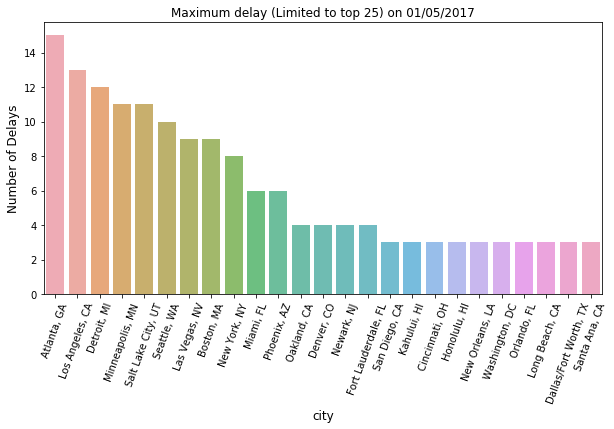

In [24]:
#df.groupby(['destinationcityname']).count()['CarrierDelay'].plot(ax=ax)
city_count  = df['destinationcityname'].value_counts()
city_count = city_count[:25,]
plt.figure(figsize=(10,5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Maximum delay (Limited to top 25) on 01/05/2017')
plt.ylabel('Number of Delays', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.xticks(rotation=70)
plt.show()


In [25]:
#Query secondary nosql (ES)


### 1.4 What is the min/max and average time between delays by delay type on a given day?

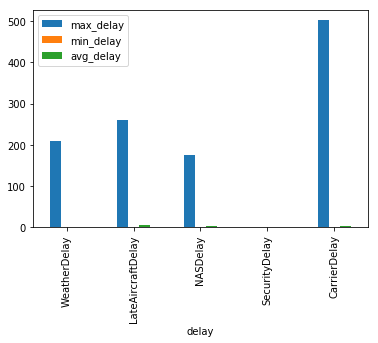

In [26]:
#Query primary nosql (cassandra)
sql1 = 'select MAX(WeatherDelay) as max_delay, MIN(WeatherDelay) as min_delay, AVG(WeatherDelay) as avg_delay \
        from thirdeye_test.airlineontime where \
        year=2017 and month =1 and dayofmonth = 5 ALLOW FILTERING'

sql2 = 'select MAX(LateAircraftDelay) as max_delay, MIN(LateAircraftDelay) as min_delay, AVG(LateAircraftDelay) as avg_delay \
        from thirdeye_test.airlineontime where \
        year=2017 and month =1 and dayofmonth = 5 ALLOW FILTERING'

sql3 = 'select MAX(NASDelay) as max_delay, MIN(NASDelay) as min_delay, AVG(NASDelay) as avg_delay \
        from thirdeye_test.airlineontime where \
        year=2017 and month =1 and dayofmonth = 5 ALLOW FILTERING'

sql4 = 'select MAX(SecurityDelay) as max_delay, MIN(SecurityDelay) as min_delay, AVG(SecurityDelay) as avg_delay \
        from thirdeye_test.airlineontime where \
        year=2017 and month =1 and dayofmonth = 5 ALLOW FILTERING'

sql5 = 'select MAX(CarrierDelay) as max_delay, MIN(CarrierDelay) as min_delay, AVG(CarrierDelay) as avg_delay \
        from thirdeye_test.airlineontime where \
        year=2017 and month =1 and dayofmonth = 5 ALLOW FILTERING'

d = {}
df = pd.DataFrame(data=d)

rows1 = session.execute(sql1)
for row1 in rows1:
    data = {
             'delay': 'WeatherDelay',
             'max_delay' : row1['max_delay'],
             'min_delay' :  row1['min_delay'],
             'avg_delay' :  row1['avg_delay'],
         }
    df = df.append(data, ignore_index=True)

rows2 = session.execute(sql2)
for row2 in rows2:
    data = {
         'delay': 'LateAircraftDelay',
         'max_delay' : row2['max_delay'],
         'min_delay' :  row2['min_delay'],
         'avg_delay' :  row2['avg_delay'],
     }
    df = df.append(data, ignore_index=True)
    
rows3 = session.execute(sql3)
for row3 in rows3:
    data = {
         'delay': 'NASDelay',
         'max_delay' : row3['max_delay'],
         'min_delay' :  row3['min_delay'],
         'avg_delay' :  row3['avg_delay'],
     }
    df = df.append(data, ignore_index=True)
    
rows4 = session.execute(sql4)
for row4 in rows4:
    data = {
         'delay': 'SecurityDelay',
         'max_delay' : row4['max_delay'],
         'min_delay' :  row4['min_delay'],
         'avg_delay' :  row4['avg_delay'],
     }
    df = df.append(data, ignore_index=True)
    
rows5 = session.execute(sql5)
for row5 in rows5:
    data = {
         'delay': 'CarrierDelay',
         'max_delay' : row5['max_delay'],
         'min_delay' :  row5['min_delay'],
         'avg_delay' :  row5['avg_delay'],
     }
    df = df.append(data, ignore_index=True)
    
df.plot(x="delay", y=["max_delay", "min_delay", "avg_delay"], kind="bar")

### 1.5 Categories the number of delays by delay type

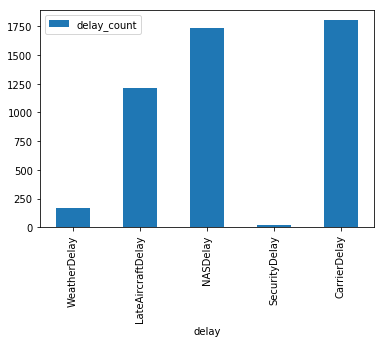

In [27]:
#Query primary nosql (cassandra)
#Query secondary nosql (ES)
sql1 = 'select count(WeatherDelay) as WeatherDelay \
        from thirdeye_test.airlineontime where \
        WeatherDelay > 0 ALLOW FILTERING'
sql2 = 'select count(LateAircraftDelay) as LateAircraftDelay \
        from thirdeye_test.airlineontime where \
        LateAircraftDelay > 0 ALLOW FILTERING'
sql3 = 'select count(NASDelay) as NASDelay \
        from thirdeye_test.airlineontime where \
        NASDelay > 0 ALLOW FILTERING'
sql4 = 'select count(SecurityDelay) as SecurityDelay \
        from thirdeye_test.airlineontime where \
        SecurityDelay > 0 ALLOW FILTERING'
sql5 = 'select count(CarrierDelay) as CarrierDelay \
        from thirdeye_test.airlineontime where \
        CarrierDelay > 0 ALLOW FILTERING'

d = {}
df = pd.DataFrame(data=d)

rows1 = session.execute(sql1)
for row1 in rows1:
    data = {
             'delay': 'WeatherDelay',
             'delay_count' : row1['weatherdelay']
         }
    df = df.append(data, ignore_index=True)

rows2 = session.execute(sql2)
for row2 in rows2:
    data = {
         'delay': 'LateAircraftDelay',
         'delay_count' : row2['lateaircraftdelay']
     }
    df = df.append(data, ignore_index=True)
    
rows3 = session.execute(sql3)
for row3 in rows3:
    data = {
         'delay': 'NASDelay',
         'delay_count' : row3['nasdelay']
     }
    df = df.append(data, ignore_index=True)
    
rows4 = session.execute(sql4)
for row4 in rows4:
    data = {
         'delay': 'SecurityDelay',
         'delay_count' : row4['securitydelay']
     }
    df = df.append(data, ignore_index=True)
    
rows5 = session.execute(sql5)
for row5 in rows5:
    data = {
         'delay': 'CarrierDelay',
         'delay_count' : row5['carrierdelay']
     }
    df = df.append(data, ignore_index=True)
    
df.plot(x="delay", y=["delay_count"], kind="bar")

In [28]:
#Query secondary nosql (ES)


### 1.6 What is the min, max and average time between the planned and actual arrival time of the aircraft by airline?

In [29]:
#Query primary nosql (cassandra)


In [30]:
#Query secondary nosql (ES)


## 2. Moderate

### 2.1 What delay type is most common at each airport (over a month, quarter or year)?

(3056, 6)


<Figure size 1152x432 with 0 Axes>

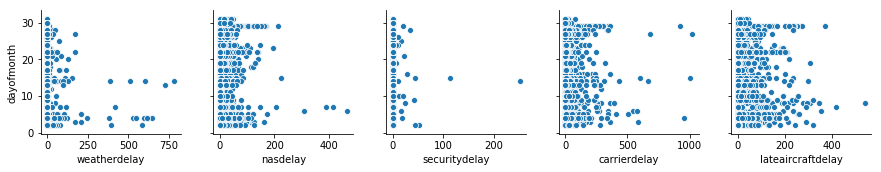

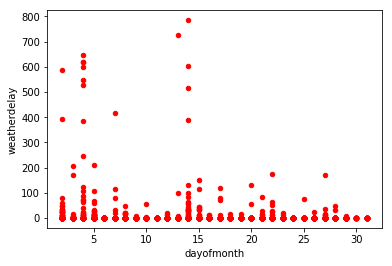

In [39]:
#NOTE: OR condition is not supported in cassandra and hence we need to fire off multiple queries to get delay data
#Query primary nosql (cassandra)
sql1 = "select dayofmonth, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay \
        from thirdeye_test.airlineontime where  ArrDel15 > 0 \
        and flight_date > '2017-01-01' AND flight_date < '2017-10-10' \
        ALLOW FILTERING"
d = {}
df = pd.DataFrame(data=d)

rows1 = session.execute(sql1)
for row1 in rows1:
    data = {
            'dayofmonth' : row1['dayofmonth'],
            'weatherdelay' : row1['weatherdelay'],
            'nasdelay' : row1['nasdelay'],
            'securitydelay' : row1['securitydelay'],
            'carrierdelay' : row1['carrierdelay'],
            'lateaircraftdelay' : row1['lateaircraftdelay'],
         }
    df = df.append(data, ignore_index=True)
print(df.shape)
#df= df.head(1000)
plt.figure(figsize=(16,6))
sns.pairplot(df, x_vars=["weatherdelay","nasdelay","securitydelay","carrierdelay","lateaircraftdelay"], y_vars="dayofmonth")


In [32]:
#Query secondary nosql (ES)


### 2.2 Did privately managed airlines perform better than publicly traded ones?

(42, 3)


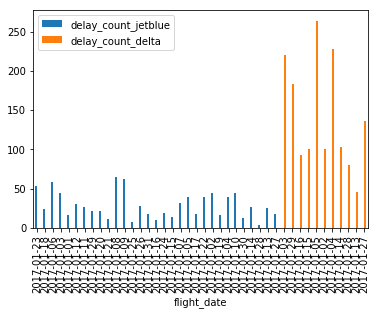

In [51]:
#Query primary nosql (cassandra)
#Data for JetBlue
sql1 = "select flight_date, count(ArrDel15) as delays from \
        thirdeye_test.airlineontime where  ArrDel15 > 0 \
        and ownership='Private' and Reporting_Airline='B6' \
        group by flight_date \
        ALLOW FILTERING"
#Data for Delta
sql2 = "select flight_date, count(ArrDel15) as delays from \
        thirdeye_test.airlineontime where  ArrDel15 > 0 \
        and ownership='Public' and Reporting_Airline='DL' \
        group by flight_date \
        ALLOW FILTERING"

d = {}
df = pd.DataFrame(data=d)

rows1 = session.execute(sql1)
for row1 in rows1:
    data = {
             'flight_date': row1['flight_date'],
             'delay_count_jetblue' : row1['delays']
         }
    df = df.append(data, ignore_index=True)

rows2 = session.execute(sql2)
for row2 in rows2:
    data = {
         'flight_date': row2['flight_date'],
         'delay_count_delta' : row2['delays']
     }
    df = df.append(data, ignore_index=True)

print(df.shape)
#df= df.head(1000)
df.plot(x="flight_date", y=["delay_count_jetblue", "delay_count_delta"], kind="bar")

In [5]:
#Query secondary nosql (ES)


### 2.3 What airline had the most delays each month?

In [64]:
#Since group by is supported only over primary key we need to fetch all records with delay > 15 mins
# and then perform grouping function in pandas
#Query primary nosql (cassandra)
sql1 = "select flight_date, Reporting_Airline, arrdel15 from thirdeye_test.airlineontime \
        where  ArrDel15 > 0 and month=1 \
        ALLOW FILTERING"
d = {}
df = pd.DataFrame(data=d)

rows1 = session.execute(sql1)
for row1 in rows1:
    data = {
             'reporting_airline': row1['reporting_airline'],
             'flight_date' : row1['flight_date'],
            'arrdel15' :row1['arrdel15']
         }
    df = df.append(data, ignore_index=True)
print(df.shape)


(3081, 3)


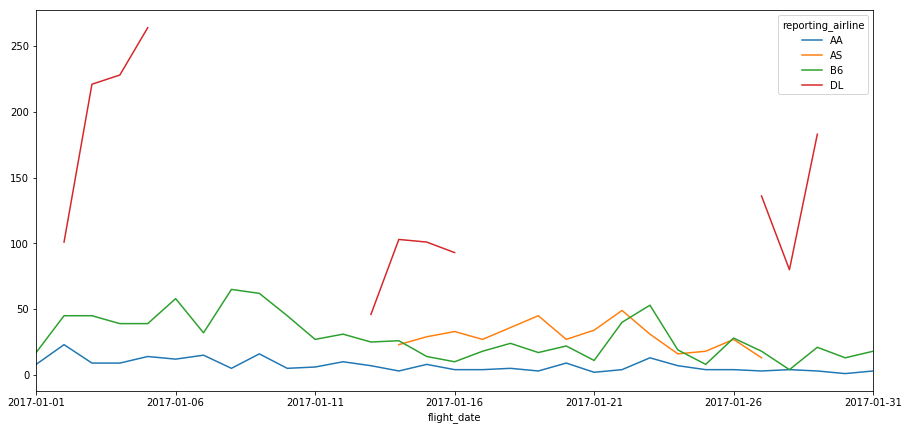

In [73]:
#gk = df.groupby(['reporting_airline', 'flight_date'])['arrdel15'].count() 
fig, ax = plt.subplots(figsize=(15,7))
#df.groupby(['reporting_airline','flight_date']).count()['arrdel15'].plot(ax=ax)
df.groupby(['flight_date','reporting_airline']).count()['arrdel15'].unstack().plot(ax=ax)



In [7]:
#Query secondary nosql (ES)


## 3. Difficult

### 3.1 How did other airlines (peers) perform during bad weather (over a month, quarter or year)?

In [8]:
#Query primary nosql (cassandra)


In [9]:
#Query secondary nosql (ES)


### 3.2. Is the airline at fault for the delay and should it compensate the customers?

In [10]:
#Query primary nosql (cassandra)


In [11]:
#Query secondary nosql (ES)


### 3.3 Was there any correlation between delay trends and companies stock performance?

In [12]:
#Query primary nosql (cassandra)


In [13]:
#Query secondary nosql (ES)


### 3.4 Did airlines with modernized fleet perform better during bad weather?

In [14]:
#Query primary nosql (cassandra)


In [30]:
#Query secondary nosql (ES)
